## Image classification with deep learning methods.

-- Description --

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.
In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.
Although you used your computer successfuly it is highly recommended to give a try to Google Colab environment.


In [29]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import numpy as np
import time
# import os
import random
import matplotlib.pyplot as plt
# from matplotlib import colors
from PIL import Image as Image
from tqdm import tqdm
# from sklearn.metrics import roc_auc_score

In [2]:
# Install and import the MedMNIST package and datasets.

# !pip install medmnist
import medmnist

## Some information from the dataset

You can browse the imaging datasets on their webpage https://medmnist.com/, and download them as such:

You can find relevant information about the datasets in the info.INFO dictionary.


In [3]:
# Some information about dataset

data_flag = 'pneumoniamnist'            # Dataset choosen
download = True                         # Download dataset (optional)

info = medmnist.INFO[data_flag]         # Extract dataset info (dictionary container)
task =          info['task']            # Classification task:  multi-class, reggresion, binary, ...
n_channels =    info['n_channels']      # Color/gray scale images
labels =        info['label']           # Extract class labels
n_classes =     len(labels)     

print(info)     

# Partial display of information in info
print("Medmnist class: "      , info['python_class'])   #  Medmnist dataset type:   BloodMNIST, ChestMNIST, DermaMNIST, ....
print("Url: "                 , info['url'])            #  Url dir
print("Classification task: " , info['task'])           #  Classification tasks:   
print("Class labels: "        , info['label'])          #  Class labels
print("Samples: "             , info['n_samples'])      #  Samples subdatasets

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [41]:
# Define dataclass instance medmnist.dataset.Bloodmnist
DataClass = getattr(medmnist, info['python_class'])  

class StandardizeImage(transforms.Transform):
    def __init__(self):
        super(StandardizeImage, self).__init__()

    def __call__(self, img):
        # Estandarizar la imagen para que tenga media 0 y desviación estándar 1
        mean = img.mean()
        std = img.std()
        return (img - mean) / std


# Definir la composición de transformaciones
t = transforms.Compose([
    transforms.ToImage(),  # Convertir a objeto de imagen
    transforms.ToDtype(torch.float32, scale=True),  # Convertir a tipo de datos float32 y escalar a [0, 1]
    StandardizeImage()  # Estandarizar la imagen (media 0, desviación estándar 1)
])

# Load datasets
train_dataset   = DataClass(split='train', size= 64, transform= t, download= download)
val_dataset     = DataClass(split='val'  , size= 64, transform= t, download= download)
test_dataset    = DataClass(split='test' , size= 64, transform= t, download= download) 

Using downloaded and verified file: C:\Users\felix\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\felix\.medmnist\pneumoniamnist_64.npz
Using downloaded and verified file: C:\Users\felix\.medmnist\pneumoniamnist_64.npz


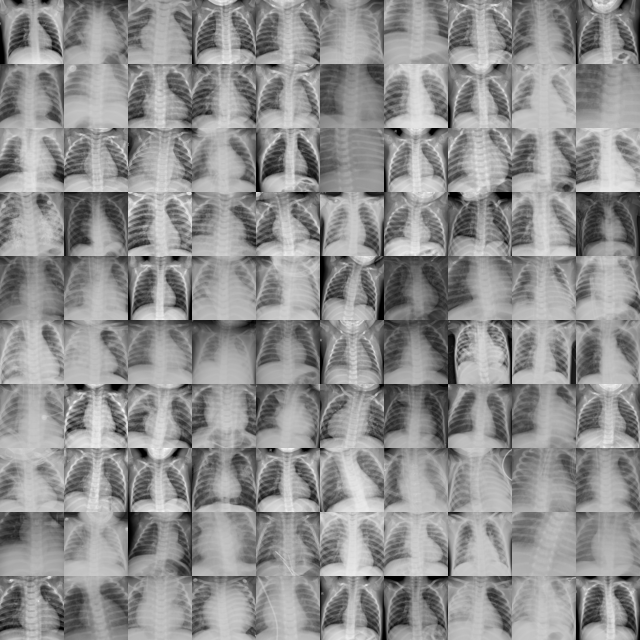

In [5]:
# Visualize some train images
train_dataset.montage(length=10)

## Pre-processing

Estandarización por canal de color.

## Generate a dataloader

A convinient option for accessing data in torch is with the use of the Dataloader class. These work directly when given a MNIST dataset as input.
You can also apply any necesary preprocesing steps directly as you load the data with the Transforms package and the transform MNIST argument.

Choose apropiate values for the training hiperparameters (you can experiment with sampling strategies if you want) and implement the adecuate preprocesing steps. Finally, choose an Mnist dataset and create the dataloader for the training, validation and test splits.

## Create a deep learning model

In [42]:
# Define el modelo U-Net
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define un conjunto de datos ficticio para la demostración
# class PneumoniaDataset(data.Dataset):
#     def __init__(self, imgs, labels, transform=None):
#         self.imgs = imgs
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.imgs)

#     def __getitem__(self, idx):
#         img = self.imgs[idx]
#         label = self.labels[idx]

#         if self.transform:
#             img = self.transform(img)

#         # Estandarization
#         mean,std = torch.mean(img), torch.std(img)
#         img = (img - mean) / std

#         return img, label

# Parámetros de entrenamiento
batch_size = 32
epochs = 10
learning_rate = 0.001

# Creación de DataLoader
# my_train_dataset = PneumoniaDataset(train_dataset.imgs, train_dataset.labels, transform=t)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Inicialización del modelo y la función de pérdida
model = UNet()
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss

# Optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entrenamiento del modelo
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")


ValueError: Target size (torch.Size([32, 1])) must be the same as input size (torch.Size([32, 1, 64, 64]))

#Train Model

Implement the main traning loop to train the deep learning model.
This should include the forward and backward passes. You can find information about how to do this with torch in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id14

In [ ]:
# Train the model

for epoch in range(NUM_EPOCHS):

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize

        #Your code


#Evaluation

Finally, implement the evaluation of the object clasification task. You can implement any metric you want, though the most common are accuracy and AUC (one class against all for the multiclass task). You can use torch.no_grad() for speeding up predictions when no gradients are needed.

How do you compare with the MedMNIST benchmarks?

In [ ]:
# Evaluation

# Your code


## Anexo

##### Cálculo de balanceo de muestras

In [78]:
def extract_n_samples(dataset, n_samples, split, verbose= False):
    total_dataset_n_samples = dataset.info['n_samples'][split]
    assert( total_dataset_n_samples <= len(dataset))

    subdataset  = copy.deepcopy(dataset)

    a = [ [] for _ in range(n_classes) ]

    # Muestras por clase
    for ind, label in enumerate(subdataset.labels):
        a[ label.item() ].append( ind )

    c = []  

    # Extracción aleatoria de los índices en proporción al número de muetras en el dataset original
    for idx, l in enumerate(a):
        ste = np.round((len(l) * n_samples) / total_dataset_n_samples).astype(np.uint16)
        samples = random.sample(l, ste) 
        c.extend([ dataset[i] for i in l ])
        if verbose:
            print("Class: ", idx, "N_samples:", len(a[idx]), " --> ", ste, " index list: ", samples )

    subdataset = c

    return subdataset

In [85]:
subdataset_example = extract_n_samples(train_dataset, 1000, 'train', True)
print( type( subdataset_example))
subdataset_example

Class:  0 N_samples: 852  -->  71  index list:  [3663, 6342, 4592, 2791, 2894, 5573, 471, 10907, 6850, 6622, 9698, 6292, 7484, 10977, 4677, 11380, 5001, 9278, 9483, 6187, 4314, 3327, 11426, 8516, 3788, 10332, 10943, 8157, 9425, 1598, 1449, 6482, 490, 2580, 4779, 4844, 2625, 10729, 1448, 5929, 10395, 2485, 1258, 6795, 4709, 6458, 11590, 2469, 9887, 10424, 8672, 11012, 11017, 6178, 1898, 2129, 9872, 10676, 779, 11005, 10927, 1725, 6083, 2651, 9741, 11447, 486, 1190, 3848, 10329, 7619]
Class:  1 N_samples: 2181  -->  182  index list:  [1966, 6827, 9969, 6727, 11548, 3326, 8456, 3739, 7187, 6362, 7504, 8923, 8314, 4876, 3694, 11630, 5498, 735, 10147, 11659, 9389, 11702, 6506, 4094, 3917, 7669, 914, 11534, 2530, 10684, 75, 10947, 11407, 2910, 6987, 11272, 8389, 6705, 10726, 11157, 9168, 3334, 1698, 7354, 9347, 5126, 1338, 8469, 7628, 6206, 2193, 1075, 2577, 2644, 10183, 3397, 4554, 4934, 11751, 8633, 6170, 423, 4962, 2773, 8099, 3379, 5031, 5493, 2157, 193, 9573, 7806, 6266, 2075, 7100, 951

[(<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=64x64>, array([0])),
 (<PIL.Image.Image image mode=RGB size=6

##### Pre-processing function


In [145]:
def norm_n_stand_dataset(dataset, debug= False):
    '''
        Normalizes and standardizes a MedMNIST dataset
    '''
    imgs = copy.deepcopy(dataset)

    # Normalization [0, 1]
    for idx, tuple in enumerate(imgs):
        img, label = tuple
        
        # Normalization
        img = np.array(img) / 255.0

        # Calculate the mean and standard deviation for each channel.
        mean = np.mean(img, axis= (0, 1), keepdims= True)    
        std  = np.std (img, axis= (0, 1), keepdims= True) 

        # Standardization
        img = ( img - mean ) / std

        imgs[idx] = [img, label]
    
    return imgs